Global seed set to 1
Global seed set to 1


Training model: {'max_steps': 50, 'callbacks': [<pytorch_lightning.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x000001F1B821D160>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x000001F1B821D7C0>], 'accelerator': 'gpu', 'devices': -1, 'enable_checkpointing': False, 'val_check_interval': 50, 'check_val_every_n_epoch': None}
32-true


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training model: {'max_steps': 50, 'callbacks': [<pytorch_lightning.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x000001F1B82984F0>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x000001F1C3E05040>], 'accelerator': 'gpu', 'devices': -1, 'enable_checkpointing': False, 'val_check_interval': 50, 'check_val_every_n_epoch': None}
32-true


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

nhits的参数量： 7313175


Validation: 0it [00:00, ?it/s]

32-true


Predicting: 0it [00:00, ?it/s]

32-true


Predicting: 0it [00:00, ?it/s]

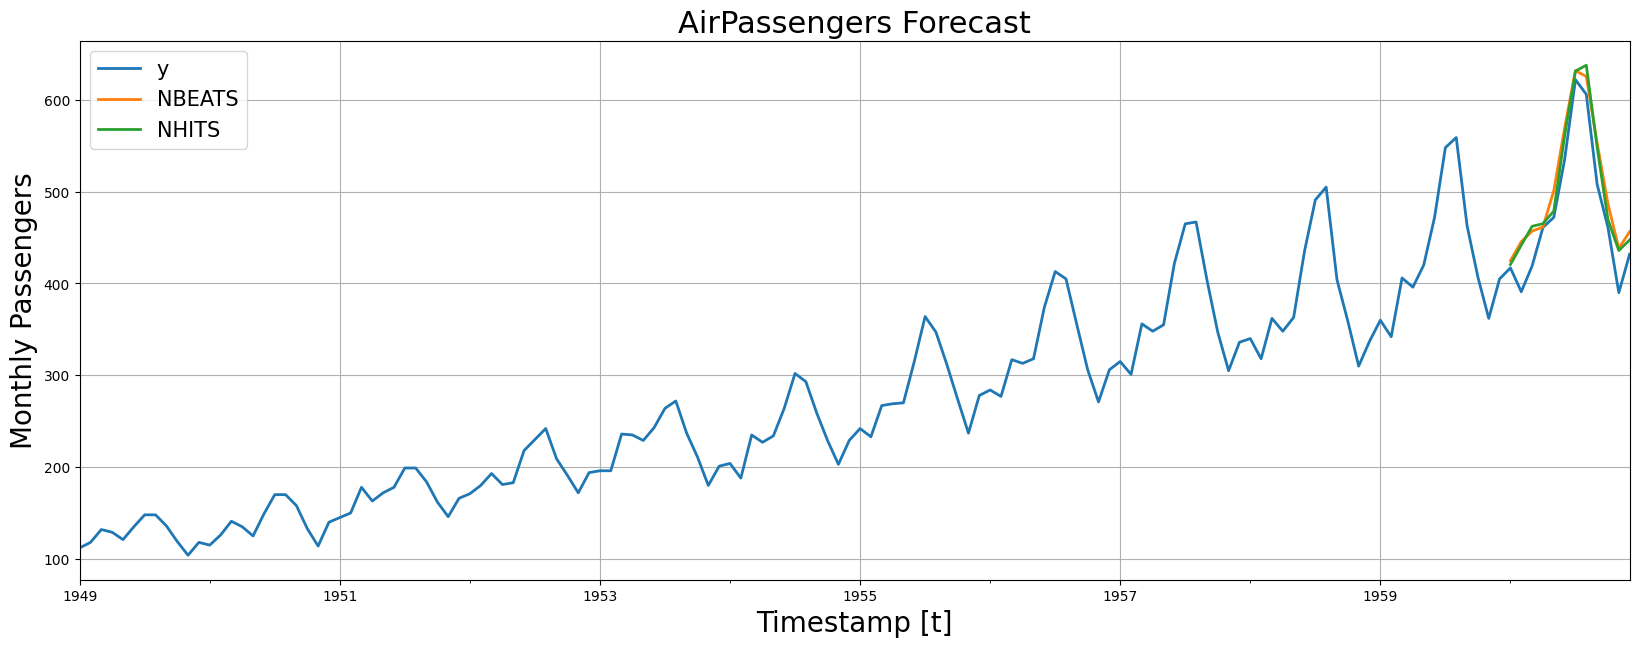

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=50)]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [1]:
### 这个文件和automixmodel是一样的，只是为了测试交叉验证的结果和
# predictisample的结果是否一致，有可能是predictisample的结果没有经过标准化。

# 经过实验证明predictinsample的结果确实没有标准化

# 监控模型训练过程中的loss， lr， parameters and gradients，先用tensorboard，后面再用wandb


import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models.mixmodel import MIXModel

from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


input_size = 512
horizon = 96
dataset = "Weather"
epochs = 100

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
# test_size = int(n_time/10)   # 10% 的数据作为测试集

Y_df.drop(columns=["index"], inplace=True)

mixmodel = MIXModel(
        h = horizon,
        input_size = input_size,
        transformer_input_size = 192,
        n_blocks = [1, 1, 1],
        mlp_units = 3 * [[256, 256]],
        n_pool_kernel_size = [16, 8, 1],
        n_freq_downsample = [16, 8, 1],
        pooling_mode = "MaxPool1d",
        interpolation_mode = "linear",
        dropout_prob_theta=0.2,
        mlp_activation = "ReLU",
        # decoder_layers = 1,
        encoder_layers = 3,
        n_heads = 16,
        hidden_size = 128,
        linear_hidden_size = 256,
        dropout = 0.2,
        fc_dropout = 0.2,
        head_dropout = 0.0,
        attn_dropout = 0.0,
        patch_len = 16,
        stride = 8,
        revin = False,    
        revin_affine = False,
        revin_subtract_last = True,
        activation = "gelu",
        res_attention = True,  # 残差链接
        batch_normalization = True, # pre-norm
        learn_pos_embed = True,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = 100,
        learning_rate = 1e-3,
        num_lr_decays = -1,
        early_stop_patience_steps = -1,
        val_check_steps = 100,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024, 
        inference_windows_batch_size = 1024,
        step_size = 2,
        scaler_type = "standard",
        random_seed = 2023,
        num_workers_loader = 0, # 取决于 cpu 数量, 死机
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader=False,
)

nf = NeuralForecast(models=[mixmodel], freq=freq)
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,step_size=1, n_windows=None)
# nf.fit(df=Y_df, val_size=val_size)
from neuralforecast.losses.numpy import mae, mse

y_true = Y_hat_df.y.values
y_hat = Y_hat_df["MIXModel"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"MIXModel {dataset} h={horizon}")
# print("test_size", test_size)
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape) # n_windows = test_size - horizon + 1
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))

Global seed set to 2023


2021-01-01 00:00:00 10539 <10 * Minutes>
16-mixed


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

16-mixed


Predicting: 0it [00:00, ?it/s]

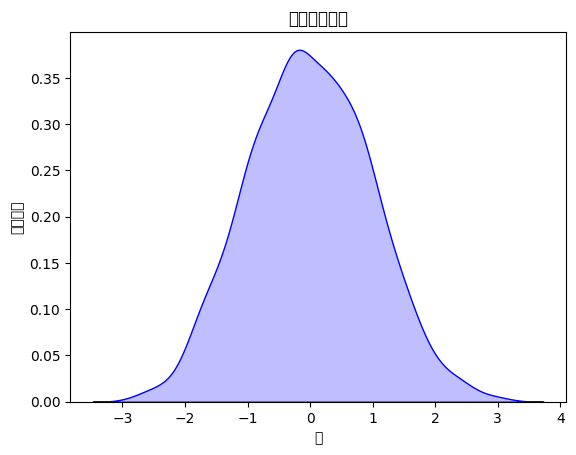

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建一个示例数组，你需要替换它为你要分析的实际数据
data = np.random.normal(0, 1, 1000)  # 这里使用了一个标准正态分布的示例数据

# 使用seaborn绘制核密度估计曲线
sns.kdeplot(data, shade=True, color='b')

plt.xlabel('值')
plt.ylabel('概率密度')
plt.title('元素分布曲线')

plt.show()
